# Определение музыкального жанра по обложке альбома

Pet-проект, чтобы потренировать навыки, приобрести новые и нескучно провести время.

Очевидно, что оформление музыкального альбома и жанр этого альбома связаны между собой. Насколько они связаны? 
Возможно ли по обожке определить жанр альбома?

## Основная задача

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обожки

## Импорты необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image


In [2]:
!pip install faiss_gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 18.8 MB/s eta 0:00:00:00:0100:01


In [3]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import faiss

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    
device

0
2
Tesla T4


device(type='cuda', index=0)

In [7]:
RS = 8
random.seed(RS)
np.random.seed(RS)
torch.manual_seed(RS)
torch.cuda.manual_seed(RS)
torch.cuda.manual_seed_all(RS)

In [8]:
path = '/kaggle/input/music-album-covers/images/images'
path_to_save = '/kaggle/working/'

## Исследование данных

In [9]:
os.listdir(path)

['disco',
 'rap',
 'black metal',
 'reggae',
 'anime',
 'classical',
 'jazz',
 'edm',
 'country',
 'pop']

In [10]:
# Список для хранения названий файлов и жанров
data = {'img': [], 'genre': [], 'img_path':[]}

# Обход всех папок в директории
for root, dirs, files in os.walk(path):
    for file in files:
        # Добавляем название файла в список img
        data['img'].append(file)
        # Добавляем название жанра (название текущей подпапки) в список genre
        data['genre'].append(os.path.basename(root))
        # Добавляем путь к файлу
        data['img_path'].append(os.path.join(root,file))
# Создаем датафрейм
df = pd.DataFrame(data)
df

img  genre  \
0     7653e2aa-9f6f-4c60-ab32-36ca3bf5031b.png  disco   
1     ebcf0cc4-995c-4f63-a326-d4a340e73a58.png  disco   
2     a24fbdb4-358b-483c-818f-ba40230c8194.png  disco   
3     0afb79bf-2181-44a5-99dc-b7ae74a90b93.png  disco   
4     0e246594-f674-4872-a628-f52e7200aec9.png  disco   
...                                        ...    ...   
7795  eca7a0db-1819-4ea0-9b57-18fe86e7c2d1.png    pop   
7796  2a80e04e-73be-4770-be51-35313b21512f.png    pop   
7797  35414336-a5b9-4e1d-a24c-97f282e804d1.png    pop   
7798  695b4a0e-985d-49a8-a315-7c7831a60ff2.png    pop   
7799  6a1943b1-4eb5-4011-939f-176e8a65da41.png    pop   

                                                                                           img_path  
0     /kaggle/input/music-album-covers/images/images/disco/7653e2aa-9f6f-4c60-ab32-36ca3bf5031b.png  
1     /kaggle/input/music-album-covers/images/images/disco/ebcf0cc4-995c-4f63-a326-d4a340e73a58.png  
2     /kaggle/input/music-album-covers/images/images/disco/a24fbdb4-358b-483c-818f-ba40230c8194.png  
3     /kaggle/input/music-album-covers/images/images/disco/0afb79bf-2181-44a5-99dc-b7ae74a90b93.png  
4     /kaggle/input/music-album-covers/images/images/disco/0e246594-f674-4872-a628-f52e7200aec9.png  
...                                                                                             ...  
7795    /kaggle/input/music-album-covers/images/images/pop/eca7a0db-1819-4ea0-9b57-18fe86e7c2d1.png  
7796    /kaggle/input/music-album-covers/images/images/pop/2a80e04e-73be-4770-be51-35313b21512f.png  
7797    /kaggle/input/music-album-covers/images/images/pop/35414336-a5b9-4e1d-a24c-97f282e804d1.png  
7798    /kaggle/input/music-album-covers/images/images/pop/695b4a0e-985d-49a8-a315-7c7831a60ff2.png  
7799    /kaggle/input/music-album-covers/images/images/pop/6a1943b1-4eb5-4011-939f-176e8a65da41.png  

[7800 rows x 3 columns]

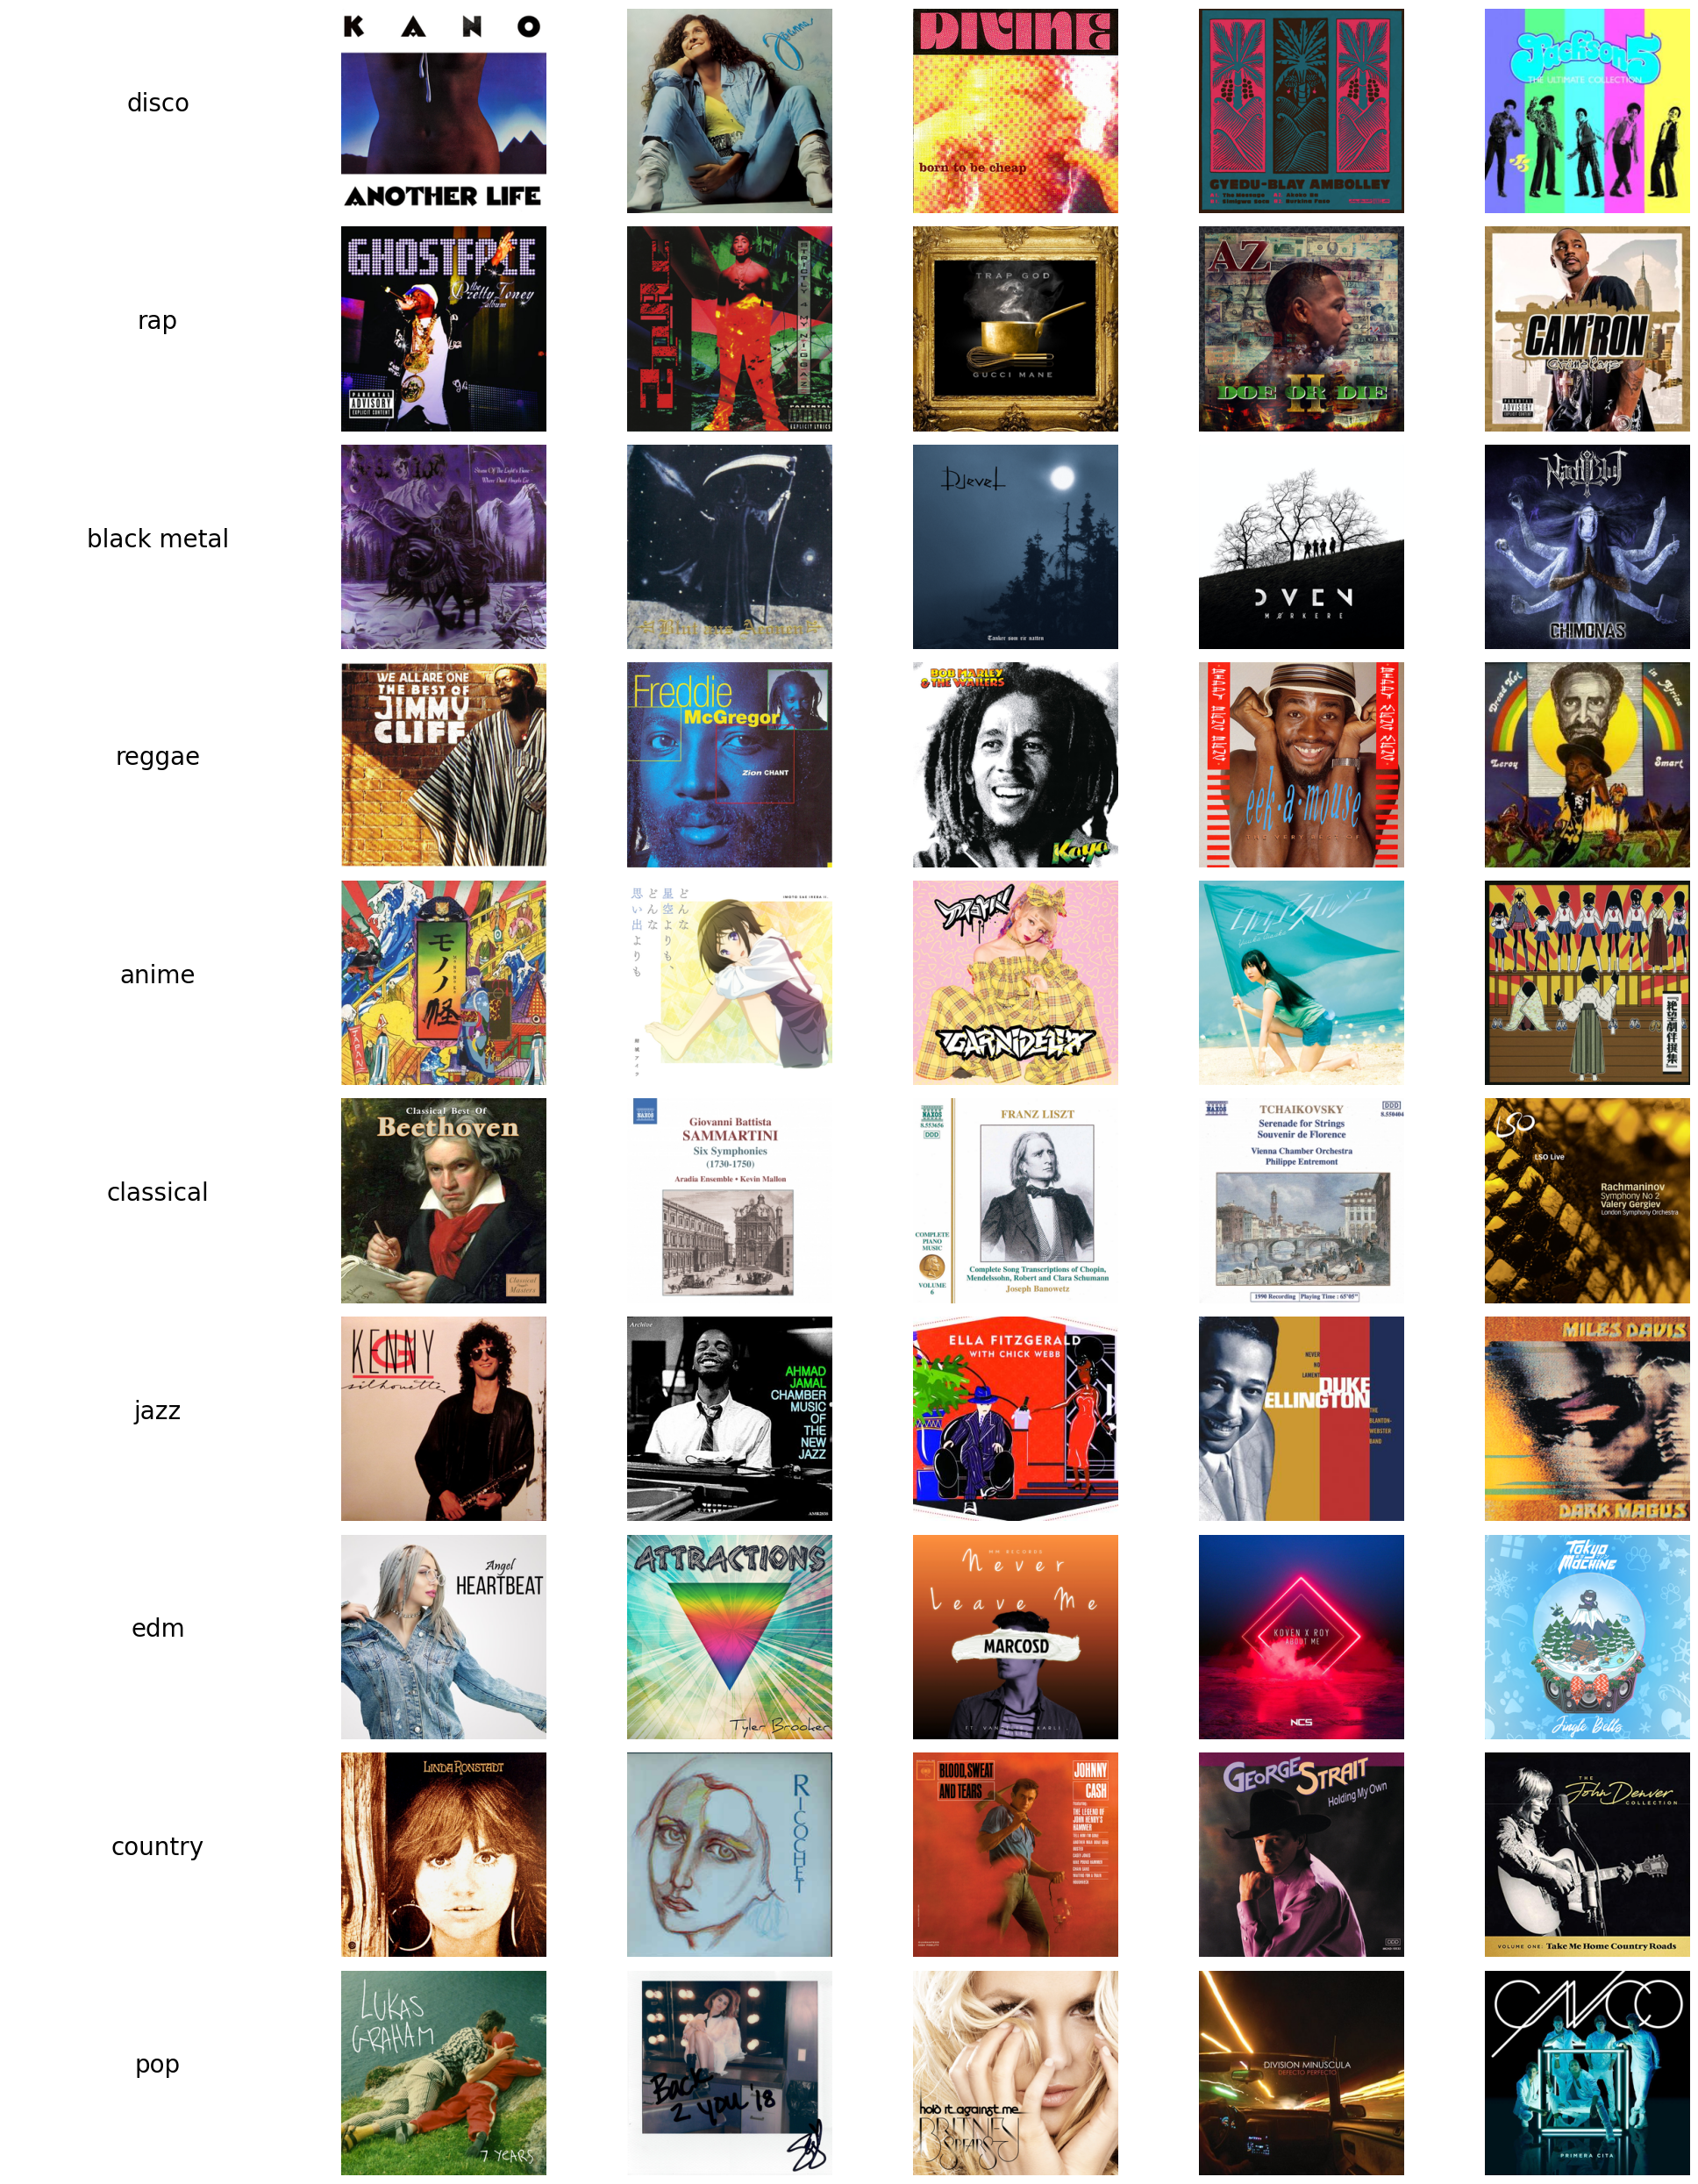

In [11]:
plt.figure(figsize=(20, 25))

# Уникальные жанры
genres = df['genre'].unique()

# Отображаем по 5 изображений для каждого жанра
num_images = 5
rows = len(genres)
cols = num_images + 1
gs = GridSpec(rows, cols)

for i, genre in enumerate(genres):
    ax = plt.subplot(gs[i, 0])
    ax.axis('off')
    ax.text(0.5, 0.5, genre, fontsize=20, ha='center')

    df_genre = df[df['genre'] == genre].sample(n=num_images, random_state=1)

    for j, img_path in enumerate(df_genre['img']):
        with Image.open(path+'/'+genre+'/'+img_path) as img:
            ax = plt.subplot(gs[i, j+1])
            ax.imshow(img)
            ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Находим изображения, относящиеся к более чем одному жанру
intersection_images = df[df.duplicated(subset='img', keep=False)].sort_values('img')

print(f'Количество изображений, относящихся к более чем одному жанру: {len(intersection_images)}')


Количество изображений, относящихся к более чем одному жанру: 8


In [13]:
# Выводим информацию о мультижанровых изображениях
for img_name, genre_list in intersection_images.groupby('img')['genre']:
    genres = ', '.join(genre_list)
    print(f'Изображение: {img_name}, Жанры: {genres}')

Изображение: 5c4f2c7c-8412-39fa-9468-23c52e285cd7.png, Жанры: disco, reggae
Изображение: 6ea3d2de-f234-4bdd-8ba8-4e9523f5ae1a.png, Жанры: disco, pop
Изображение: 7e5955d3-c4f3-493c-a3d4-8b855bfc1833.png, Жанры: rap, pop
Изображение: 9123d325-bf8e-4423-be98-98478dccee20.png, Жанры: rap, pop


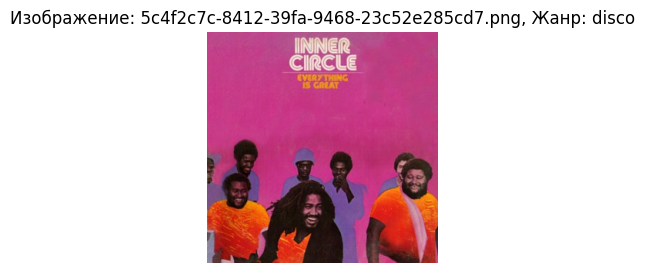

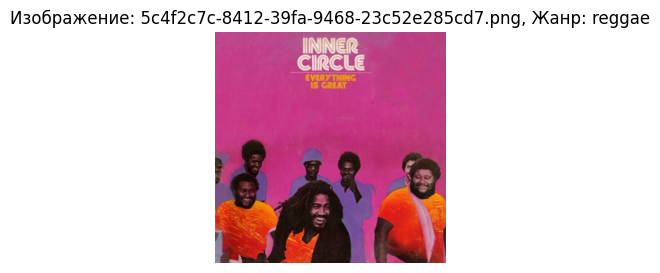

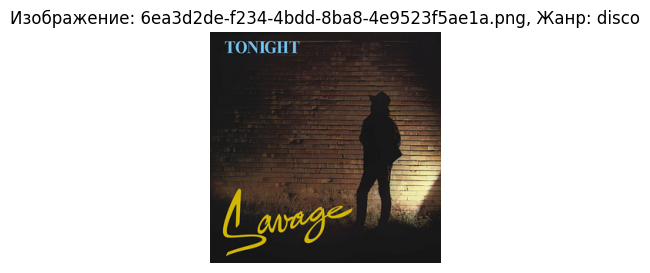

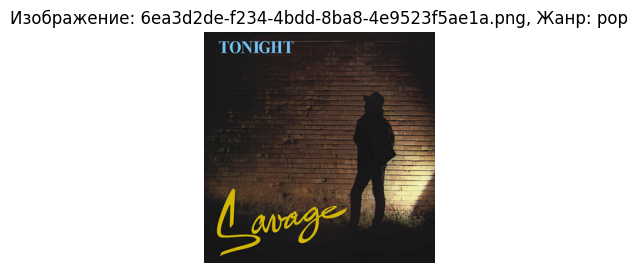

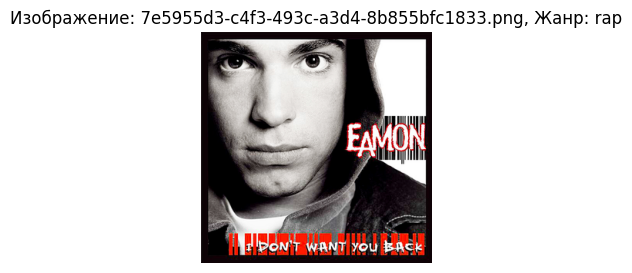

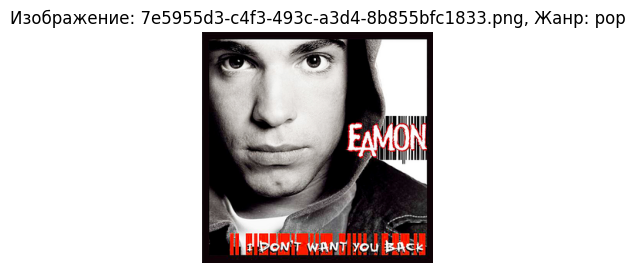

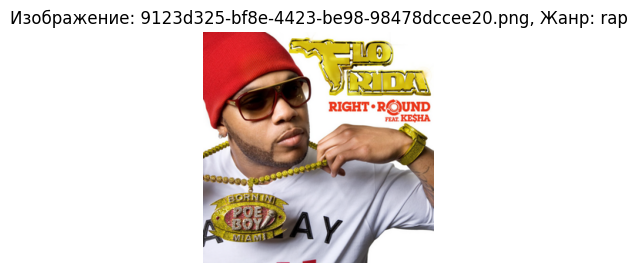

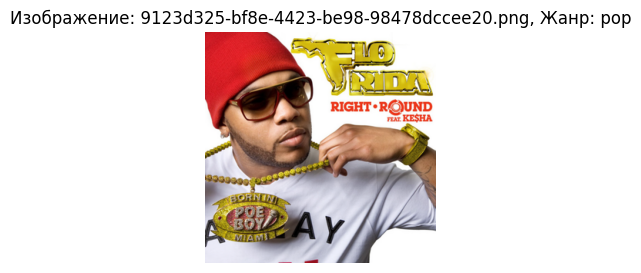

In [14]:
for i, row in intersection_images.iterrows():
    img = Image.open(row['img_path'])
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Изображение: {row.img}, Жанр: {row.genre}')
    plt.show() 

У нас нет оснований относить эти альбомы к одному определенному жанру - поэтому удалим дубликаты. (Альтернативно можно решить эту проблему в рамках мультилейбл классификации).

In [15]:
df.drop_duplicates(['img'], keep=False, inplace=True)
len(df)

7792

### Баланс классов

In [16]:
df.groupby('genre').count()

img  img_path
genre                      
anime        1189      1189
black metal   450       450
classical     955       955
country      1486      1486
disco         466       466
edm           719       719
jazz          821       821
pop           800       800
rap           326       326
reggae        580       580

 Наблюдается дисбаланс классов.

## Baseline

Реализуем бейзлайн:
- вычислим эмбеддинги изображений с помощью нейронной сети resnet50 предобученной на IMAGENET
- определение жанра будем выполнять следующим образом: с помощью метода поиска ближайших соседей найдем наиболее похожие изображения альбомов с известными жанрами и методом взвешенного голосования определим искомы жанр.

### Вычисление эмбеддингов

In [17]:
# Путь к папке с изображениями
DATA_DIR = path

# Путь к папке с эмбеддингами
EMB_DIR = path_to_save

# Создание модели ResNet50

# Set model to eval mode
model = models.get_model('resnet50', weights="DEFAULT")
model = torch.nn.Sequential(*list(model.children())[:-1])
model.cuda();
model.eval()

def create_embeddings(data_dir, emb_dir):
    print('Создаем эмбеддинги изображений из папки', data_dir)
    class ImageDataset(Dataset):
        def __init__(self, data_dir):
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
            self.images = []
            self.labels = []

            print('Читаем и предобрабатываем изображения')
            for i, genre in tqdm(enumerate(os.listdir(data_dir))):
                for image_path in os.listdir(os.path.join(data_dir, genre)):
                    img = Image.open(os.path.join(data_dir, genre, image_path)).convert('RGB')
                    img_tensor = self.transform(img)
                    self.images.append(img_tensor)
                    self.labels.append(genre)
        
        def __len__(self):
            return len(self.images)
        
        def __getitem__(self, idx):
            return self.images[idx], self.labels[idx]
            
    all_labels = []
    all_embeddings = []      
    dataset = ImageDataset(data_dir)
    dataloader = DataLoader(dataset, batch_size=32)
    torch.cuda.empty_cache() 

    print('Вычисляем эмбеддинги')
    for data,labels in tqdm(dataloader):
        with torch.no_grad():
            new_labels = list(labels)
            all_labels += new_labels
            data = data.cuda()
            embeddings = model(data.cuda())
            all_embeddings.append(np.reshape(embeddings.detach().cpu(),(len(new_labels),-1)))
    all_embeddings = np.vstack(all_embeddings)
    
    
    X = all_embeddings
    y =  np.array(all_labels)
    DATA_PATH = os.path.join(emb_dir, 'embeddings.npy')
    LABELS_PATH = os.path.join(emb_dir, 'labels.npy')
    print('Сохраняем эмбеддинги изображений и соответствующие им жанры(labels)')
    np.save(DATA_PATH, X)
    np.save(LABELS_PATH, y)
    return X,y

def load_embeddings(emb_dir):
    try:
        X = np.load(os.path.join(emb_dir, 'embeddings.npy'))
        y = np.load(os.path.join(emb_dir, 'labels.npy'))
        print('Эмбеддинги загружены из файла')
    except:
        print('Файлы эмбеддингов не найдены')
    return X,y

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


In [18]:
try:
    X,y = load_embeddings(EMB_DIR)
except:
    X,y = create_embeddings(DATA_DIR, EMB_DIR)

Файлы эмбеддингов не найдены
Создаем эмбеддинги изображений из папки /kaggle/input/music-album-covers/images/images
Читаем и предобрабатываем изображения


10it [01:37,  9.80s/it]


Вычисляем эмбеддинги


100%|██████████| 244/244 [00:22<00:00, 10.71it/s]


Сохраняем эмбеддинги изображений и соответствующие им жанры(labels)


### Определение жанра по наиболее похожим изображениям (по ближайшим соседям)

In [19]:
def prediction(neighbors, D):
    """Выбирает наиболее подходящую метку из neighbors с учетом расстояний.

    Args:
        neighbors: Массив меток соседей.
        D: Массив расстояний до ближайших соседей.

    Returns:
        Метка наиболее подходящего соседа.
    """

    # Вычисляет среднее расстояние для каждой метки.
    avg_distances = np.mean(D, axis=0)

    # Выбирает метку с минимальным средним расстоянием.
    best_neighbor = neighbors[np.argmin(avg_distances)]

    return best_neighbor

    
# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Создаем индекс FAISS
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

# Выполняем поиск ближайших соседей
k = 5
D, I = index.search(X_test, k)

# Для каждого тестового изображения получаем жанр по ближайшим соседям
y_pred = np.array([prediction(y_train[I[i]], D[i]) for i in range(len(X_test))])

# Выводим classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anime       0.65      0.67      0.66       119
 black metal       0.79      0.67      0.72        45
   classical       0.51      0.60      0.55        95
     country       0.49      0.50      0.50       149
       disco       0.22      0.17      0.19        47
         edm       0.65      0.47      0.55        72
        jazz       0.30      0.37      0.33        82
         pop       0.45      0.41      0.43        80
         rap       0.32      0.30      0.31        33
      reggae       0.35      0.38      0.37        58

    accuracy                           0.49       780
   macro avg       0.47      0.45      0.46       780
weighted avg       0.49      0.49      0.49       780



### Выводы по бейзлайну

- Средний Accuracy = 0,49. 
- Точность определения по жанрам составляет от 0,22 до 0,79. 
- лучше всего с точностью выше 0,65 определяются anime, black metal и edm
- на втором месте с точностью от 0,45 до 0,51 находятся pop, classical и country
- хуже всего с точностью от 0,22 до 0,35 определяются disco, jazz, rap и reggae

## Подбор модели

Проведем несколько экспериментов для подбора модели, которая лучше справится с поставленной задачей. 

Будем использовать бибилиотеку fast.ai

### Загрузчик изображений

Создадим загрузчик изображений и применим аугментации по умолчанию, которые разработчики библиотеки fast.ai считают дают хороший результат на большинстве данных.

In [20]:
df.head()

img  genre  \
0  7653e2aa-9f6f-4c60-ab32-36ca3bf5031b.png  disco   
1  ebcf0cc4-995c-4f63-a326-d4a340e73a58.png  disco   
2  a24fbdb4-358b-483c-818f-ba40230c8194.png  disco   
3  0afb79bf-2181-44a5-99dc-b7ae74a90b93.png  disco   
4  0e246594-f674-4872-a628-f52e7200aec9.png  disco   

                                                                                        img_path  
0  /kaggle/input/music-album-covers/images/images/disco/7653e2aa-9f6f-4c60-ab32-36ca3bf5031b.png  
1  /kaggle/input/music-album-covers/images/images/disco/ebcf0cc4-995c-4f63-a326-d4a340e73a58.png  
2  /kaggle/input/music-album-covers/images/images/disco/a24fbdb4-358b-483c-818f-ba40230c8194.png  
3  /kaggle/input/music-album-covers/images/images/disco/0afb79bf-2181-44a5-99dc-b7ae74a90b93.png  
4  /kaggle/input/music-album-covers/images/images/disco/0e246594-f674-4872-a628-f52e7200aec9.png

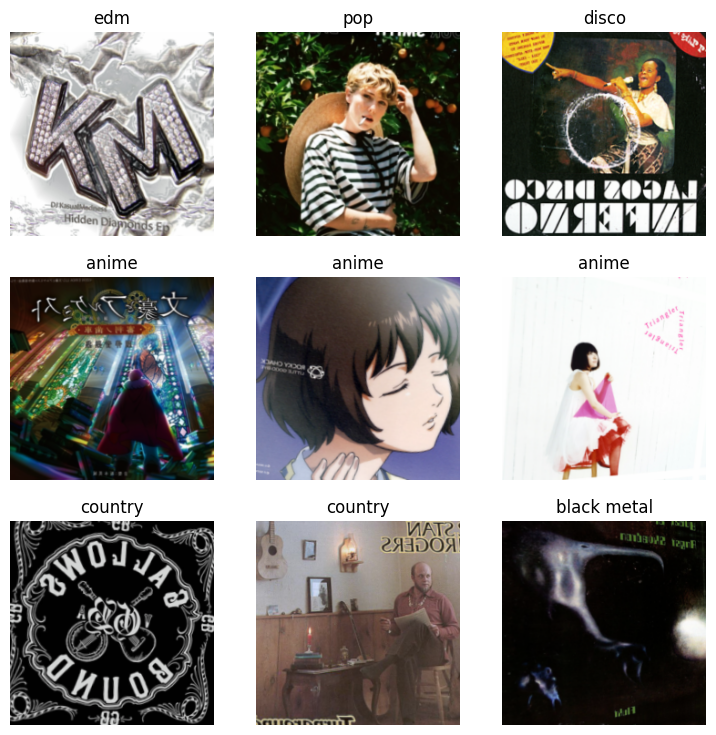

In [68]:
dls = ImageDataLoaders.from_df(
    df,
    path='/',
    fn_col='img_path',
    label_col ='genre',
    valid_pct=0.1,
    seed=RS,
    bs=64,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224)
)
dls.show_batch()

In [77]:
results=[]

## resnet18 fine tuning

Дообучим модель resnet18 с помощью метода fine_tune c параметрами по умолчанию (на одной эпохе обновляет веса последнего слоя, затем размораживает остальные слои и обновляет их на последующих эпохах, используя discriminative LR - для первых слоев LR поменьше, для последних - побольше).

Также для экономии памяти и увеличения скорости используем fp16 (half-precision floating-point format - формат с плавающей запятой половинной точности).

In [65]:
model = resnet18

In [66]:
# Параметры для сохранения лучшей модели в процессе обучения и
# и ранней остановки если нет улучшения valid_loss в течение 8 эпох

cbs=[
        SaveModelCallback(),
        EarlyStoppingCallback(min_delta=0.001, patience=8)
    ]

## Эксперимент 1 (fine_tune с параметрами по умолчанию)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s] 


Better model found at epoch 0 with valid_loss value: 1.6062127351760864.


Better model found at epoch 0 with valid_loss value: 1.367190957069397.
Better model found at epoch 1 with valid_loss value: 1.3075107336044312.
Better model found at epoch 2 with valid_loss value: 1.2646822929382324.
Better model found at epoch 3 with valid_loss value: 1.2307827472686768.
No improvement since epoch 3: early stopping


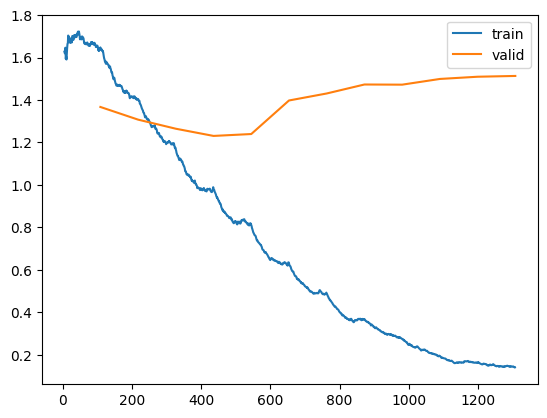

In [24]:

learn = vision_learner(dls, model, path='/kaggle/working/resnet18/exp1/', metrics=accuracy).to_fp16()
learn.fine_tune(13, cbs=cbs)
learn.recorder.plot_loss(skip_start=5, with_valid=True)

In [78]:
results.append({
    'model':model.__name__,
    'Эксперимент': 'Эксперимент 1 (fine_tune с параметрами по умолчанию)',
    'accuracy': 0.618742
    })

train_loss быстро уменьшается, в то время как valid_loss увеличивается после эпохи №3 второй фазы обучения (на рамороженной сети). Accuracу = 0.618742 (на последней эпохе, где valid loss уменьшался). 

## Эксперимент 2 (fine_tune с freeze_epochs=3)

Проведем эксперимент, в ходе которого на первом этапе мы будем обучать только последний слой в течение трех эпох. Затем, на следующем этапе, мы будем обучать все слои в течение оставшихся эпох.

Better model found at epoch 0 with valid_loss value: 1.71785569190979.
Better model found at epoch 1 with valid_loss value: 1.484181523323059.
Better model found at epoch 2 with valid_loss value: 1.3897595405578613.


Better model found at epoch 0 with valid_loss value: 1.2618143558502197.
Better model found at epoch 1 with valid_loss value: 1.1751713752746582.
No improvement since epoch 1: early stopping


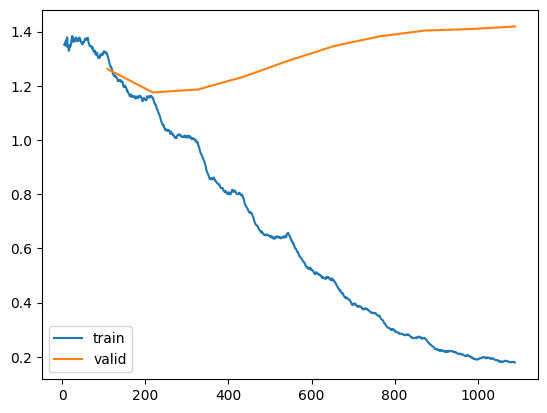

In [25]:
learn = vision_learner(dls, model, path='/kaggle/working/resnet18/exp2/', metrics=accuracy).to_fp16()
learn.fine_tune(10, freeze_epochs=3, cbs=cbs)
learn.recorder.plot_loss(skip_start=5, with_valid=True)

In [81]:
results.append({
    'model':model.__name__,
    'Эксперимент': 'Эксперимент 2 (fine_tune с freeze_epochs=3)',
    'accuracy': 0.620026
    })

Accuracу = 0.620026 (на последней эпохе, где valid loss уменьшался). Немного лучше предыдущего эксперимента.

## Эксперимент 3 (fit_one_cycle - 2 этапа с подбором LR) 

Попробуем улучшить результат.

В начале эксперимента мы подберем оптимальное значение learning rate (LR) для последнего слоя и проведем обучение в течение трех эпох. Затем мы разморозим остальные слои и уточним диапазон изменения LR. После этого мы продолжим обучение на 20 эпохах.

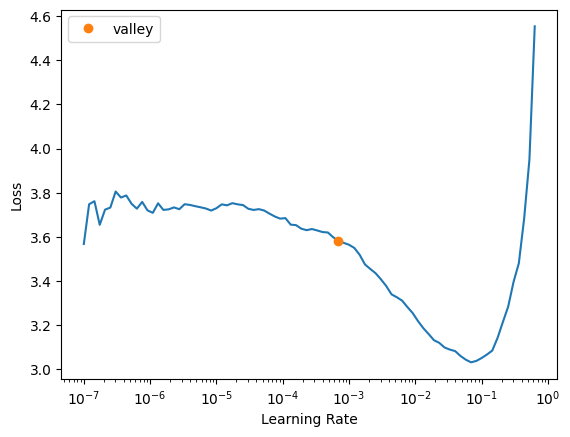

lr_valley= 0.0006918309954926372


Better model found at epoch 0 with valid_loss value: 1.5292305946350098.
Better model found at epoch 1 with valid_loss value: 1.425742506980896.
Better model found at epoch 2 with valid_loss value: 1.3985612392425537.


In [69]:
learn = vision_learner(dls, model, path='/kaggle/working/resnet18/exp3/', cbs=cbs, metrics=accuracy).to_fp16()
lr_valley = learn.lr_find().valley
plt.show()
print('lr_valley=',lr_valley)
learn.fit_one_cycle(3, lr_valley)

SuggestedLRs(valley=0.0004786300996784121)

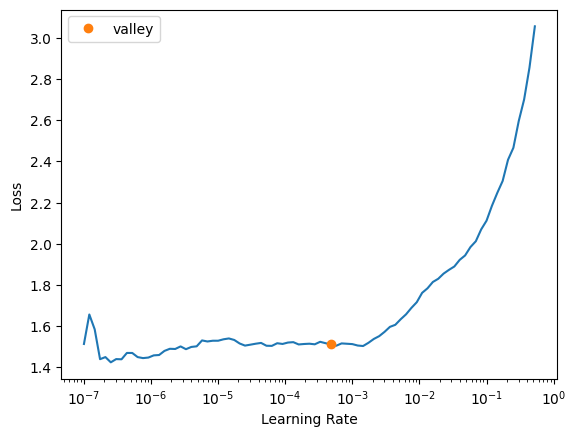

In [70]:
learn.unfreeze()
learn.lr_find()

Better model found at epoch 0 with valid_loss value: 1.3817743062973022.
Better model found at epoch 1 with valid_loss value: 1.3558968305587769.
Better model found at epoch 2 with valid_loss value: 1.3174684047698975.
Better model found at epoch 3 with valid_loss value: 1.2789223194122314.
No improvement since epoch 3: early stopping


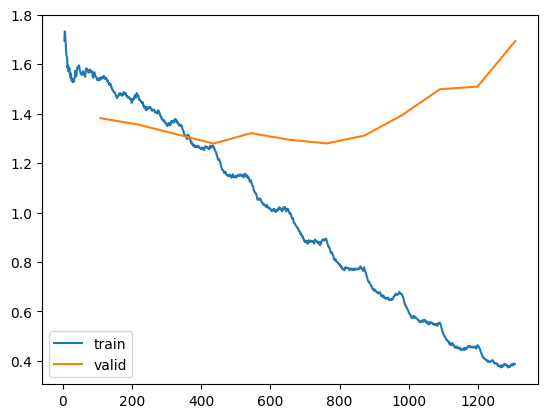

In [71]:
learn.fit_one_cycle(40, lr_max=slice(1e-5/3,2e-3))
learn.recorder.plot_loss(skip_start=5, with_valid=True)

In [83]:
results.append({
    'model':model.__name__,
    'Эксперимент': 'Эксперимент 3 (fit_one_cycle - 2 этапа с подбором LR)',
    'accuracy': 0.600770
    })

Accuracу = 0.600770 (на последней эпохе, где valid loss уменьшался). Улучшения не наблюдается.

## resnet50 fine tuning

In [89]:
model=resnet50
cbs=[
        SaveModelCallback(),
        EarlyStoppingCallback(min_delta=0.001, patience=8)
    ]

## Эксперимент 1 (fine_tune с параметрами по умолчанию)

Better model found at epoch 0 with valid_loss value: 1.4360195398330688.


Better model found at epoch 0 with valid_loss value: 1.2338680028915405.
Better model found at epoch 1 with valid_loss value: 1.1851412057876587.
Better model found at epoch 2 with valid_loss value: 1.146734595298767.
Better model found at epoch 3 with valid_loss value: 1.1163957118988037.
Better model found at epoch 4 with valid_loss value: 1.0947908163070679.
No improvement since epoch 4: early stopping


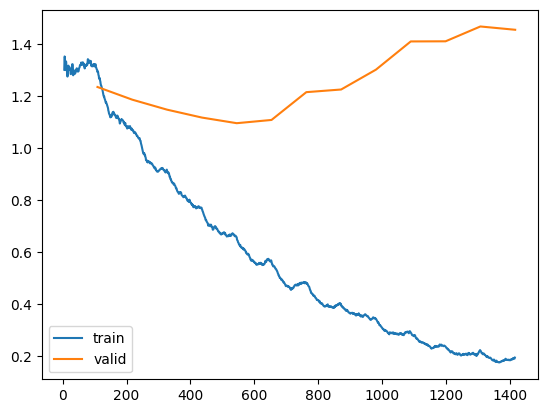

In [30]:
learn = vision_learner(dls, model, path='/kaggle/working/resnet50/exp1/', cbs=cbs, metrics=accuracy).to_fp16()
learn.fine_tune(40, freeze_epochs=1)
learn.recorder.plot_loss(skip_start=5, with_valid=True)


In [90]:
results.append({
    'model':model.__name__,
    'Эксперимент': 'Эксперимент 1 (fine_tune с параметрами по умолчанию)',
    'accuracy': 0.663671
    })

Accuracу = 0.663671 (на последней эпохе, где valid loss уменьшался). Значительно лучше resnet18.

## Эксперимент 2 (fine_tune с freeze_epochs=3)

Better model found at epoch 0 with valid_loss value: 1.510722279548645.
Better model found at epoch 1 with valid_loss value: 1.348620891571045.
Better model found at epoch 2 with valid_loss value: 1.2167155742645264.


Better model found at epoch 0 with valid_loss value: 1.1345399618148804.
Better model found at epoch 1 with valid_loss value: 1.076533317565918.
Better model found at epoch 2 with valid_loss value: 1.0471529960632324.
No improvement since epoch 2: early stopping


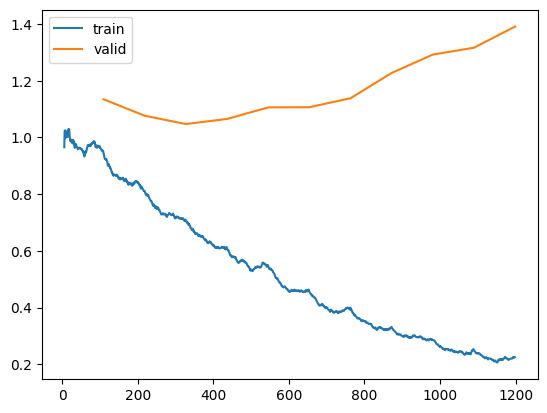

In [31]:
learn = vision_learner(dls, model, path='/kaggle/working/resnet50/exp2/', cbs=cbs, metrics=accuracy).to_fp16()
learn.fine_tune(40, freeze_epochs=3)
learn.recorder.plot_loss(skip_start=5, with_valid=True)

In [92]:
results.append({
    'model':model.__name__,
    'Эксперимент': 'Эксперимент 2 (fine_tune с freeze_epochs=3)',
    'accuracy': 0.675225
    })

Accuracу = 0.675225 (на последней эпохе, где valid loss уменьшался). Значительно лучше предыдущего.

## Эксперимент 3 (fine_tune с freeze_epochs=3 и FocalLoss())

Better model found at epoch 0 with valid_loss value: 1.135874629020691.
Better model found at epoch 1 with valid_loss value: 1.0671145915985107.
Better model found at epoch 2 with valid_loss value: 0.9403671622276306.


Better model found at epoch 0 with valid_loss value: 0.798539400100708.
Better model found at epoch 1 with valid_loss value: 0.7709659337997437.
Better model found at epoch 2 with valid_loss value: 0.7537749409675598.
Better model found at epoch 3 with valid_loss value: 0.7319849133491516.
Better model found at epoch 4 with valid_loss value: 0.7068551778793335.
No improvement since epoch 4: early stopping


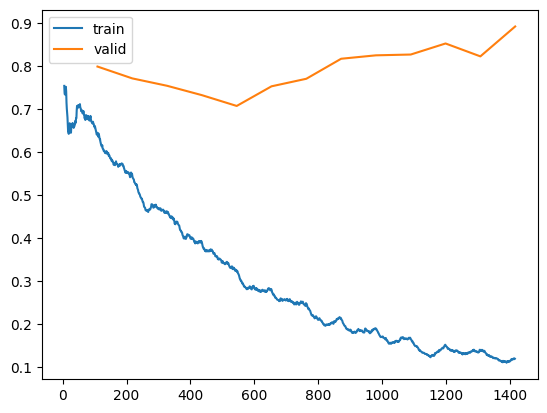

In [44]:
learn = vision_learner(dls, model, path='/kaggle/working/resnet50/exp3/', 
                       cbs=cbs, 
                       metrics=accuracy,
                      loss_func=FocalLoss(),
                      ).to_fp16()
learn.fine_tune(40, freeze_epochs=3)
learn.recorder.plot_loss(skip_start=5, with_valid=True)

In [94]:
results.append({
    'model':model.__name__,
    'Эксперимент': 'Эксперимент 3 (fine_tune с freeze_epochs=3 и FocalLoss())',
    'accuracy': 0.667522
    })

Accuracу = 0.667522 (на последней эпохе, где valid loss уменьшался). Немного хуже предыдущего.

## Интерпретация результатов

In [97]:
pd.DataFrame(results).sort_values('accuracy', ascending=False)

model                                                Эксперимент  \
4  resnet50                Эксперимент 2 (fine_tune с freeze_epochs=3)   
5  resnet50  Эксперимент 3 (fine_tune с freeze_epochs=3 и FocalLoss())   
3  resnet50       Эксперимент 1 (fine_tune с параметрами по умолчанию)   
1  resnet18                Эксперимент 2 (fine_tune с freeze_epochs=3)   
0  resnet18       Эксперимент 1 (fine_tune с параметрами по умолчанию)   
2  resnet18      Эксперимент 3 (fit_one_cycle - 2 этапа с подбором LR)   

   accuracy  
4  0.675225  
5  0.667522  
3  0.663671  
1  0.620026  
0  0.618742  
2  0.600770

- более глубокая сеть дает лучший результат resnet50 лучше resnet18
- наилучший результат среди проведенных экспериментов показала resnet50 при дообучении с заморозкой на первых трех эпохах и последующей разморозко на поледующих эпохах

Загрузим наилучшую модель

In [98]:
model = resnet50
cbs=[
        SaveModelCallback(),
        EarlyStoppingCallback(min_delta=0.001, patience=8)
    ]

In [99]:

learn = vision_learner(dls, model, path='/kaggle/working/resnet50/exp2/', cbs=cbs, metrics=accuracy).to_fp16()
learn = learn.load('/kaggle/working/resnet50/exp2/models/model',  with_opt=False)

### Матрица ошибок

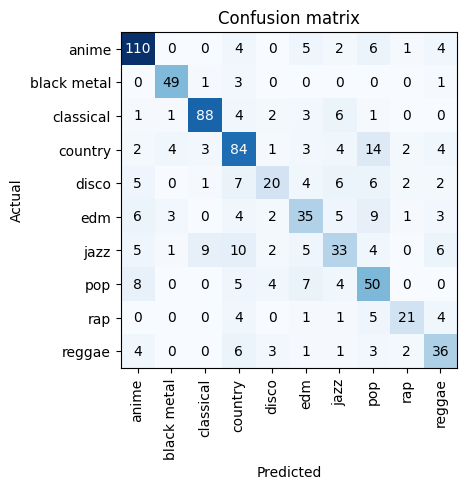

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
plt.show()

Матрица ошибок показывает, какие жанры модель путает. Например, jazz часто путает с country, classical и наоборот. 

In [53]:
y_pred, y_true = learn.get_preds(dl=dls.valid)
y_pred = y_pred.argmax(dim=1)
y_pred = [dls.categorize.vocab[index] for index in y_pred]
y_true = [dls.categorize.vocab[index] for index in y_true]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       anime       0.78      0.83      0.81       132
 black metal       0.84      0.91      0.88        54
   classical       0.86      0.83      0.85       106
     country       0.64      0.69      0.67       121
       disco       0.59      0.38      0.46        53
         edm       0.55      0.51      0.53        68
        jazz       0.53      0.44      0.48        75
         pop       0.51      0.64      0.57        78
         rap       0.72      0.58      0.65        36
      reggae       0.60      0.64      0.62        56

    accuracy                           0.68       779
   macro avg       0.66      0.65      0.65       779
weighted avg       0.67      0.68      0.67       779



Из отчета видим, что наиболее уверенно модель определяет anime, black metal и classical с точностью 0.78, 0.84 и 0.86 соответственно, а хуже всего edm, pop и rap с точностью 0.55, 0.53, 0.51 соответствено.

## Заключение

Мы провели несколько экспериментов по дообучению разных моделей нейронных сетей для определения музыкального жанра по обложке альбома.

Жанр музыки определяется именно музыкой, а не изображением альбома. Вполне возможна ситуация когда издатель для альбома музыканта может использовать изображение совсем не типичное для жанра. Но как видим все же прослеживаются некоторые закономерности в офромлении тех или иных жанров и модель достаточно успешно справляется с выявлением этих закономерностей и очень уверенно определяет некоторые жанры.

## To Do

1. **Кластеризация**: исследовать, какие жанры лучше выделяются на фоне других, а какие – трудноразделимы.
2. **API [MusicBrainz](https://musicbrainz.org/)**: расширение датасета новыми изображениями. Можно расширить список жанров и использовать обратную сторону обложки.
3. **OCR + NLP**: извлечь текст из изображения и обогатить решение применением NLP.
4. Создать **рекомендательную систему** в миниатюре, опираясь на изображения.
5. **Streamlit** оформить классификатор жанров или рекомендательную систему в виде веб-приложения.